# Chesapeake Bay Conservancy Land Cover Classifier
- inspiration:
  - https://www.esri.com/about/newsroom/arcnews/high-resolution-land-cover-data-helps-restore-chesapeake-bay-watershed/
  - https://developers.arcgis.com/python/samples/land-cover-classification-using-unet/


In [ ]:
#!pip install ipywidgets # already installed
#!pip install nodejs # fix map display issue

In [ ]:
# attempted module workarounds for broken classifier and vizualizations
# import os
# #import arcpy
# from pathlib import Path

# from arcgis import GIS
# #from arcgis.widgets import MapView
# from arcgis.learn import UnetClassifier, prepare_data

# from arcgis.mapping import WebMap

In [ ]:
import os
import arcgis
import pathlib
from pathlib import Path
from arcgis import widgets
from arcgis.widgets import MapView
from arcgis import GIS
from arcgis import learn
#from arcgis.learn import UnetClassifier, prepare_data

In [ ]:
# unet = arcgis.learn.UnetClassifier(data, backbone=None, pretrained_path=None)
# unet

### connect to GIS database

In [ ]:
ent_gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')
gis = GIS()

In [ ]:
# connect my local computer to the gis, so I have permissions for use from the univeristy
# >>> from arcgis.gis import GIS
# >>> gis = GIS(profile="umn")

# >>> more_origins = {"allowedOrigins":"http://localhost:8889"} #replace your port

# >>> gis.update_properties(more_origins)

### get labeled training data from GIS database
- CBC has prepared a huge labeled dataset for training
- here we grab a small county sized subset for our classifier from Esri's online data python api
- 1m resolution pixel labeled raster of kent county de

<Item title:"Kent_county_full_label_land_cover" type:Map Image Layer owner:api_data_owner>
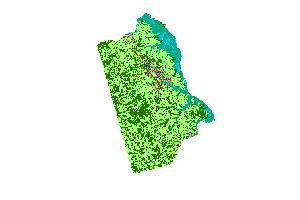

In [ ]:
label_layer = ent_gis.content.search("title: Kent_county_full_label_land_cover owner:api_data_owner", 
                                 "Map Image Layer")[0] # the index might change
#label_layer = gis.content.search("title: Kent_county_full_label_land_cover owner:api_data_owner", 
#                                 "Map Image Layer")#[0] # the index might change
label_layer

TypeError: item type must be web map

### grab the input raster layer for classification
- generic sample data from esri's world imagery online data set
- the base imagery we want to classify
- full data set contains all og band info
- we'll use the index [n] to identify the IR layer and isolate that from the imagery object at index 1 to create a imagery layer with one band

<Item title:"WorldImagery_AOI_NewYork" type:Map Image Layer owner:api_data_owner>
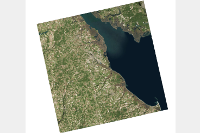

In [ ]:
world_imagery_item = ent_gis.content.search("title: WorldImagery_AOI_NewYork owner:api_data_owner", 
                                 "Map Image Layer")[0] # the index might change
world_imagery_item

In [ ]:
world_imagery_layer = world_imagery_item.layers[0]

world_imagery_layer

<MapRasterLayer url:"https://pythonapi.playground.esri.com/server/rest/services/Hosted/WorldImagery_AOI_NewYork/MapServer/0">

### visualize the map and add layers

In [ ]:
#m = ent_gis.map("Kent county, Delaware")
m = gis.map("Kent county, Delaware")
m

MapView(layout=Layout(height='400px', width='100%'))

In [ ]:
# try adding layer to the map with arcpy
# import arcpy

# aprx = arcpy.mp.ArcGISProject("CURRENT")
# m = aprx.listMaps("Map")[0]

# #print(m)

# m.addLayer(world_imagery_layer)

ValueError: [<MapRasterLayer url:"https://pythonapi.playground.esri.com/server/rest/services/Hosted/WorldImagery_AOI_NewYork/MapServer/0">]

In [ ]:
#from arcgis import realtime
#add layers
m.add_layer(world_imagery_layer)
m.add_layer(label_layer)

ModuleNotFoundError: No module named 'arcgis.realtime.StreamLayer'

In [ ]:
# Maps won't display for some reason. This is a test to see if I can initialize a world map.
from arcgis.gis import GIS

#Create a map 
gis = GIS()
map1 = gis.map("Kent county, Delaware")
map1

MapView(layout=Layout(height='400px', width='100%'))

### initialize raster analytics and set storage path

In [ ]:
#import raster analytics module
from arcgis.raster import analytics

In [ ]:
#set the data storeage path, where outputs labels and meta data are to be stored

ds = analytics.get_datastores(gis=ent_gis)
ds

<DatastoreManager for https://pythonapi.playground.esri.com/ra/admin>

In [ ]:
# display path and data type
ds.search()

[<Datastore title:"/fileShares/ListDatastoreContent" type:"folder">, <Datastore title:"/rasterStores/RasterDataStore" type:"rasterStore">]

In [ ]:
# request data
rasterstore = ds.get("/rasterStores/RasterDataStore")
rasterstore

<Datastore title:"/rasterStores/RasterDataStore" type:"rasterStore">

In [ ]:
# test request
samplefolder = "landcover_sample_world_imagery"
samplefolder

'landcover_sample_world_imagery'

### export training data withthe arcgis.learn ML module

In [ ]:
# set output to verbose for better insight into what's happening
#arcgis.env.verbose = True

import arcgis
from arcgis import learn
arcgis.env.verbose = True

#### WARNING
- this next part can take a long time (30min to 2hrs) to run
- run it once and do not re run unless you want an updated output

In [ ]:
#!pip install arcpy

# import arcpy
# arcpy.CheckOutExtension("ImageAnalyst")
# from arcpy.ia import *

In [ ]:
# Uncomment to re-run

export = learn.export_training_data(input_raster = world_imagery_layer,
                                    output_location = samplefolder,
                                    input_class_data = label_layer.url, 
                                    chip_format = "PNG", 
                                    tile_size = {"x":400,"y":400}, 
                                    stride_size = {"x":0,"y":0}, 
                                    metadata_format = "Classified_Tiles",                                        
                                    context = {"startIndex": 0, "exportAllTiles": False, "cellSize": 2},
 #                                   context = context,
                                    gis = ent_gis)

ModuleNotFoundError: No module named 'torch'

### now that the training data is created, look at the samples

In [ ]:
from arcgis.raster.analytics import list_datastore_content

samples = list_datastore_content(rasterstore.datapath + '/' + samplefolder + "/images", filter = "*png")
# print out the first five chips/subimages
samples[0:5]

This GIS does not support raster analysis.


AttributeError: 'NoneType' object has no attribute 'list_datastore_content'

In [ ]:
labels = list_datastore_content(rasterstore.datapath + '/' + samplefolder + "/labels", filter = "*png")
# print out the labels images for the first five chips
labels[0:5]

AttributeError: 'NoneType' object has no attribute 'list_datastore_content'

## Train the Model


In [ ]:
#set the GIS
gis = GIS("home")

In [ ]:
training_data = gis.content.get('e2d37d87c4f548bb4b89b259b8373a904')
training_data

In [ ]:
# change this to the filepath where my training data is stored
filepath = training_data.download(file_name=training_data.name)

AttributeError: 'NoneType' object has no attribute 'download'

In [ ]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

NameError: name 'filepath' is not defined

In [ ]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [ ]:
data = prepare_data(data_path, batch_size=16)

## Visualize the training data, see what we're working with

In [ ]:
# show batch function displays a random sample from the training image file set as the path above
data.show_batch()

## Initialize the ML model

In [ ]:
model = UnetClassifier(data)

## Train the Model- Transfer Learning technique

In [ ]:
# use the learning rate module to visualize the learning rate and determine where to optimize
# where the model's learning rate drops out can help set the LR range
lr = model.lr_find()

## Run the Model with 10 epochs with the above learning rate as parameter lr

In [ ]:
model.fit(10, lr=lr)

In [ ]:
# visualize the results
model.show_results()

## Save the MOdel to disk

In [ ]:
# change the name as epochs advance
# publish parameter automatically publishes the model on the portal as a deep learning package
model.save('stage-1-10', publish=True, gis=ent_gis)